# Plots to see distribution of data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    
    return df[features]

def check_handover(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y.iloc[i] == y.iloc[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y.iloc[i] == 0 and y.iloc[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y.iloc[i] == 1 and y.iloc[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)


In [31]:
def plot_mode(mode, operator:str, colors=mode_colors):
    n_5g = np.sum(mode) / len(mode) * 100
    fig = plt.figure(figsize=(16, 4))
    plt.grid(zorder=0)
    plt.plot(mode, color=colors[1], label='Mode', zorder=2)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('Mode')
    plt.ylim((-0.2, 1.6))
    plt.yticks([0, 1], ['4G', '5G'])
    plt.suptitle(f'Mode in campaign for {operator}')
    plt.title(f'Percentage of 5G in the campaign: {n_5g:.1f}%', fontsize=16)
    plt.legend(ncols=3, loc='best')
    plt.tight_layout()
    plt.show()

    return fig

def plot_signal_strengths(df, operator:str, xlim=None):
    hos_5g = check_handover(df['Mode'], '5g')
    hos_4g = check_handover(df['Mode'], '4g')

    when_5g_ho = []
    when_4g_ho = []

    for i in range(len(hos_5g)):
        if hos_5g[i] == 1:
            when_5g_ho.append(i)
        if hos_4g[i] == 1:
            when_4g_ho.append(i)

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    plt.suptitle(f'Signal strength values for {operator}', fontweight='semibold')

    axes[0, 0].plot(when_5g_ho, [-105 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G', zorder=10)
    axes[0, 0].plot(when_4g_ho, [-105 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G', zorder=10)
    axes[0, 0].plot(df['RSRP'].values, color=rsrp_colors[1])
    axes[0, 0].set_title('RSRP')

    axes[0, 1].plot(when_5g_ho, [20 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G', zorder=10)
    axes[0, 1].plot(when_4g_ho, [20 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G', zorder=10)
    axes[0, 1].plot(df['SINR'].values, color=sinr_colors[1])
    axes[0, 1].set_title('SINR')

    axes[0, 2].plot(when_5g_ho, [-25 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G', zorder=10)
    axes[0, 2].plot(when_4g_ho, [-25 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G', zorder=10)
    axes[0, 2].plot(df['RSRQ'].values, color=rsrq_colors[1])
    axes[0, 2].set_title('RSRQ')

    axes[1, 0].plot(when_5g_ho, [-105 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G', zorder=10)
    axes[1, 0].plot(when_4g_ho, [-105 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G', zorder=10)
    axes[1, 0].plot(df['SSS_RSRP'].values, color=rsrp_colors[1])
    axes[1, 0].set_title('SSS-RSRP')

    axes[1, 1].plot(when_5g_ho, [20 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G', zorder=10)
    axes[1, 1].plot(when_4g_ho, [20 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G', zorder=10)
    axes[1, 1].plot(df['SSS_SINR'].values, color=sinr_colors[1])
    axes[1, 1].set_title('SSS-SINR')

    when5g = axes[1, 2].plot(when_5g_ho, [-25 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G', zorder=10)
    when4g = axes[1, 2].plot(when_4g_ho, [-25 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G', zorder=10)
    axes[1, 2].plot(df['SSS_RSRQ'].values, color=rsrq_colors[1])
    axes[1, 2].set_title('SSS-RSRQ')

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_xlabel('Time')
        ax.set_xlim(xlim)
    fig.legend(handles=[when5g[0], when4g[0]], loc='lower center', bbox_to_anchor=(0.5, -0.04), fancybox=True, shadow=True, ncol=2)
    fig.tight_layout()
    plt.show

    return fig

In [5]:
op1_df = read_dataset('datasets/Op1_merged.csv')
op2_df = read_dataset('datasets/Op2_merged.csv')

op1 = 'Op1'
op2 = 'Op2'

op1_campaigns = op1_df['campaign'].unique().tolist()
op2_campaigns = op2_df['campaign'].unique().tolist()

In [6]:
fig = go.Figure()

for campaign in op1_campaigns:
    current_route = op1_df[op1_df['campaign'] == campaign]
    fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=f'Route {op1_campaigns.index(campaign)}'))

fig.update_layout(
    height=510,
    width=530,
    mapbox=dict(
        style='carto-positron',
        zoom=11,
        center=dict(lon=op1_df['Longitude'].mean()-0.015, lat=op1_df['Latitude'].mean()-0.005)
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
fig.show()
fig.write_image(format='pdf', file=r'../latex/plots/maps/op1_all_routes.pdf')

In [7]:
fig = go.Figure()

for campaign in op2_campaigns:
    current_route = op2_df[op2_df['campaign'] == campaign]
    fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=f'Route {op2_campaigns.index(campaign)}'))

fig.update_layout(
    height=510,
    width=530,
    mapbox=dict(
        style='carto-positron',
        zoom=11,
        center=dict(lon=op2_df['Longitude'].mean()-0.008, lat=op2_df['Latitude'].mean()-0.008)
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
fig.show()
fig.write_image(format='pdf', file=r'../latex/plots/maps/op2_all_routes.pdf')

In [8]:
op1_overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']
op2_overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
               'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
               'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']


op1_df = read_dataset('datasets/Op1_merged.csv', campaigns=op1_overlap[0:4])
op1_df_one_campaign = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap[0]])
op2_df = read_dataset('datasets/Op2_merged.csv', campaigns=op2_overlap[0:3])
op2_df_one_campaign = read_dataset('datasets/Op2_merged.csv', campaigns=[op2_overlap[0]])

route_to_add = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap[4]])
op1_df = pd.concat([route_to_add[5400::], op1_df])
op1_df.reset_index(drop=True, inplace=True)

route_to_add = read_dataset('datasets/Op1_merged.csv', campaigns=[op1_overlap[5]])
op1_df = pd.concat([route_to_add[0:1180], op1_df])
op1_df.reset_index(drop=True, inplace=True)

route_to_add = read_dataset('datasets/Op2_merged.csv', campaigns=[op2_overlap[3]])
op2_df = pd.concat([route_to_add[5350::], op2_df])
op2_df.reset_index(drop=True, inplace=True)

op1_campaigns = op1_df['campaign'].unique().tolist()
op2_campaigns = op2_df['campaign'].unique().tolist()

op1_mode = op1_df['Mode']
op2_mode = op2_df['Mode']

print(f'OP1 datapoints: {len(op1_mode)}\n5G in OP1 ≈ {np.sum(op1_mode) / len(op1_mode) * 100:.1f}\n4G in OP1 ≈ {(1 - np.sum(op1_mode) / len(op1_mode)) * 100:.1f}\n')
print(f'OP2 datapoints: {len(op2_mode)}\n5G in OP2 ≈ {np.sum(op2_mode) / len(op2_mode) * 100:.1f}\n4G in OP2 ≈ {(1 - np.sum(op2_mode) / len(op2_mode)) * 100:.1f}')

OP1 datapoints: 11688
5G in OP1 ≈ 28.4
4G in OP1 ≈ 71.6

OP2 datapoints: 10333
5G in OP2 ≈ 54.1
4G in OP2 ≈ 45.9


In [9]:
op1_df.iloc[32::].head()

RSRP   SINR   RSRQ  SSS_RSRP  SSS_SINR  SSS_RSRQ  \
32 -97.98  12.04 -16.39    -105.6      12.8     -10.5   
33 -97.98  12.04 -16.39    -105.6      12.8     -10.5   
34 -97.98  12.04 -16.39    -105.6      12.8     -10.5   
35 -97.98  12.04 -16.39    -105.6      12.8     -10.5   
36 -97.98  12.04 -16.39    -105.6      12.8     -10.5   

                                             campaign  Mode   Latitude  \
32  Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...     0  41.824234   
33  Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...     0  41.824234   
34  Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...     0  41.824230   
35  Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...     1  41.824221   
36  Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via...     1  41.824210   

    Longitude  
32  12.465787  
33  12.465788  
34  12.465803  
35  12.465835  
36  12.465873

In [10]:
op1_test = op1_df[op1_df['campaign'] == op1_overlap[0]]
op2_test = op2_df[op2_df['campaign'] == op2_overlap[0]]

op1_test_mode = op1_test['Mode']
op2_test_mode = op2_test['Mode']

print(f'OP1 test datapoints: {len(op1_test_mode)}\n5G in OP1 ≈ {np.sum(op1_test_mode) / len(op1_test_mode) * 100:.1f}\n4G in OP1 ≈ {(1 - np.sum(op1_test_mode) / len(op1_test_mode)) * 100:.1f}\n')
print(f'OP2 test datapoints: {len(op2_test_mode)}\n5G in OP2 ≈ {np.sum(op2_test_mode) / len(op2_test_mode) * 100:.1f}\n4G in OP2 ≈ {(1 - np.sum(op2_test_mode) / len(op2_test_mode)) * 100:.1f}')

OP1 test datapoints: 2957
5G in OP1 ≈ 45.2
4G in OP1 ≈ 54.8

OP2 test datapoints: 3652
5G in OP2 ≈ 66.9
4G in OP2 ≈ 33.1


In [11]:
op1_sum = op1_df[op1_df['campaign'] == op1_overlap[1]]
op2_sum = op2_df[op2_df['campaign'] == op2_overlap[1]]

op1_sum = op1_sum['Mode']
op2_sum = op2_sum['Mode']

print(f'OP1 test datapoints: {len(op1_sum)}\n5G in OP1 ≈ {np.sum(op1_sum) / len(op1_sum) * 100:.1f}\n4G in OP1 ≈ {(1 - np.sum(op1_sum) / len(op1_sum)) * 100:.1f}\n')
print(f'OP2 test datapoints: {len(op2_sum)}\n5G in OP2 ≈ {np.sum(op2_sum) / len(op2_sum) * 100:.1f}\n4G in OP2 ≈ {(1 - np.sum(op2_sum) / len(op2_sum)) * 100:.1f}')

OP1 test datapoints: 2224
5G in OP1 ≈ 17.3
4G in OP1 ≈ 82.7

OP2 test datapoints: 2335
5G in OP2 ≈ 55.6
4G in OP2 ≈ 44.4


In [12]:
op1_sum = op1_df[op1_df['campaign'] == op1_overlap[2]]
op2_sum = op2_df[op2_df['campaign'] == op2_overlap[2]]

op1_sum = op1_sum['Mode']
op2_sum = op2_sum['Mode']

print(f'OP1 test datapoints: {len(op1_sum)}\n5G in OP1 ≈ {np.sum(op1_sum) / len(op1_sum) * 100:.1f}\n4G in OP1 ≈ {(1 - np.sum(op1_sum) / len(op1_sum)) * 100:.1f}\n')
print(f'OP2 test datapoints: {len(op2_sum)}\n5G in OP2 ≈ {np.sum(op2_sum) / len(op2_sum) * 100:.1f}\n4G in OP2 ≈ {(1 - np.sum(op2_sum) / len(op2_sum)) * 100:.1f}')

OP1 test datapoints: 2205
5G in OP1 ≈ 45.3
4G in OP1 ≈ 54.7

OP2 test datapoints: 3261
5G in OP2 ≈ 44.5
4G in OP2 ≈ 55.5


In [13]:
op1_sum = op1_df[op1_df['campaign'] == op1_overlap[3]]
op2_sum = op2_df[op2_df['campaign'] == op2_overlap[3]]

op1_sum = op1_sum['Mode']
op2_sum = op2_sum['Mode']

print(f'OP1 test datapoints: {len(op1_sum)}\n5G in OP1 ≈ {np.sum(op1_sum) / len(op1_sum) * 100:.1f}\n4G in OP1 ≈ {(1 - np.sum(op1_sum) / len(op1_sum)) * 100:.1f}\n')
print(f'OP2 test datapoints: {len(op2_sum)}\n5G in OP2 ≈ {np.sum(op2_sum) / len(op2_sum) * 100:.1f}\n4G in OP2 ≈ {(1 - np.sum(op2_sum) / len(op2_sum)) * 100:.1f}')

OP1 test datapoints: 1919
5G in OP1 ≈ 11.5
4G in OP1 ≈ 88.5

OP2 test datapoints: 1085
5G in OP2 ≈ 37.1
4G in OP2 ≈ 62.9


In [14]:
op1_sum = op1_df[op1_df['campaign'] == op1_overlap[4]]

op1_sum = op1_sum['Mode']

print(f'OP1 test datapoints: {len(op1_sum)}\n5G in OP1 ≈ {np.sum(op1_sum) / len(op1_sum) * 100:.1f}\n4G in OP1 ≈ {(1 - np.sum(op1_sum) / len(op1_sum)) * 100:.1f}')

OP1 test datapoints: 1203
5G in OP1 ≈ 2.0
4G in OP1 ≈ 98.0


In [15]:
op1_sum = op1_df[op1_df['campaign'] == op1_overlap[1]]
op2_sum = op2_df[op2_df['campaign'] == op2_overlap[1]]

op1_sum = op1_sum['Mode']
op2_sum = op2_sum['Mode']

print(f'OP1 test datapoints: {len(op1_sum)}\n5G in OP1 ≈ {np.sum(op1_sum) / len(op1_sum) * 100:.1f}\n4G in OP1 ≈ {(1 - np.sum(op1_sum) / len(op1_sum)) * 100:.1f}')

OP1 test datapoints: 2224
5G in OP1 ≈ 17.3
4G in OP1 ≈ 82.7


In [64]:
fig = go.Figure()

for campaign in op1_campaigns:
    current_route = op1_df[op1_df['campaign'] == campaign]
    fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=f'Route {op1_campaigns.index(campaign)}'))

fig.update_layout(
    height=510,
    width=530,
    mapbox=dict(
        style='carto-positron',
        zoom=12.2,
        center=dict(lon=op1_df['Longitude'].mean(), lat=op1_df['Latitude'].mean()+0.005)
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
fig.show()
fig.write_image(format='pdf', file=r'../latex/plots/maps/op1.pdf')

In [65]:
fig = go.Figure()

for campaign in op2_campaigns:
    current_route = op2_df[op2_df['campaign'] == campaign]
    fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=f'Route {op2_campaigns.index(campaign)}'))

fig.update_layout(
    height=510,
    width=530,
    mapbox=dict(
        style='carto-positron',
        zoom=12.2,
        center=dict(lon=op1_df['Longitude'].mean(), lat=op1_df['Latitude'].mean()+0.005)
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
fig.show()
fig.write_image(format='pdf', file=r'../latex/plots/maps/op2.pdf')

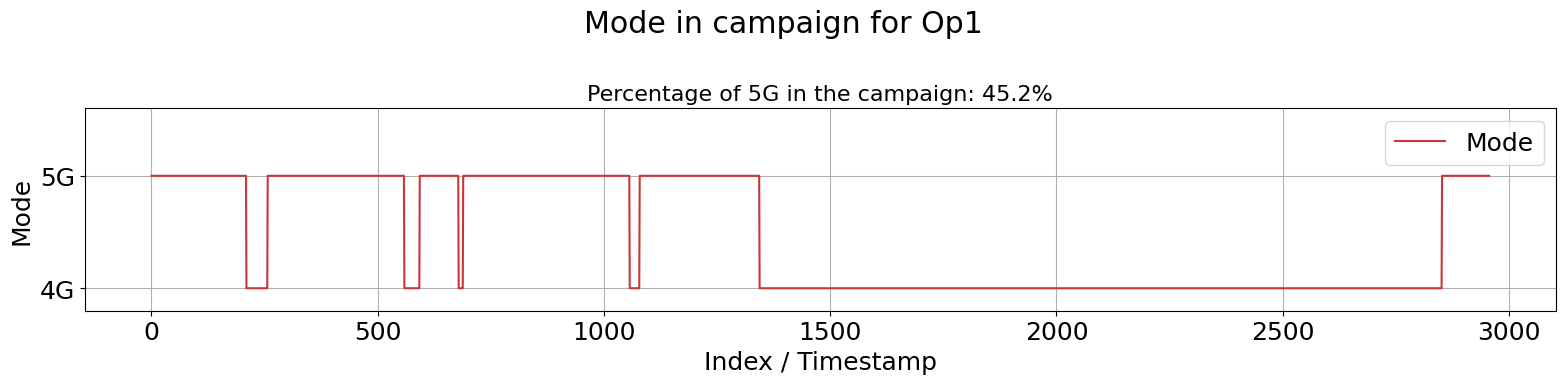

In [66]:
fig = plot_mode(mode=op1_df_one_campaign['Mode'].values, operator=op1)
fig.savefig(r'../latex/plots/overview/op1_mode.pdf')

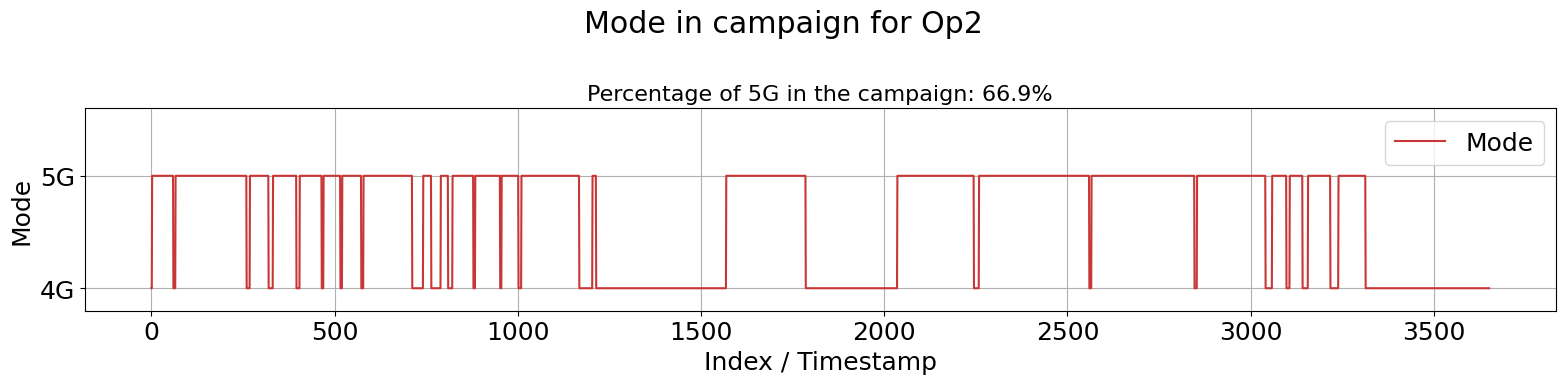

In [67]:
fig = plot_mode(mode=op2_df_one_campaign['Mode'].values, operator=op2)
fig.savefig(r'../latex/plots/overview/op2_mode.pdf')

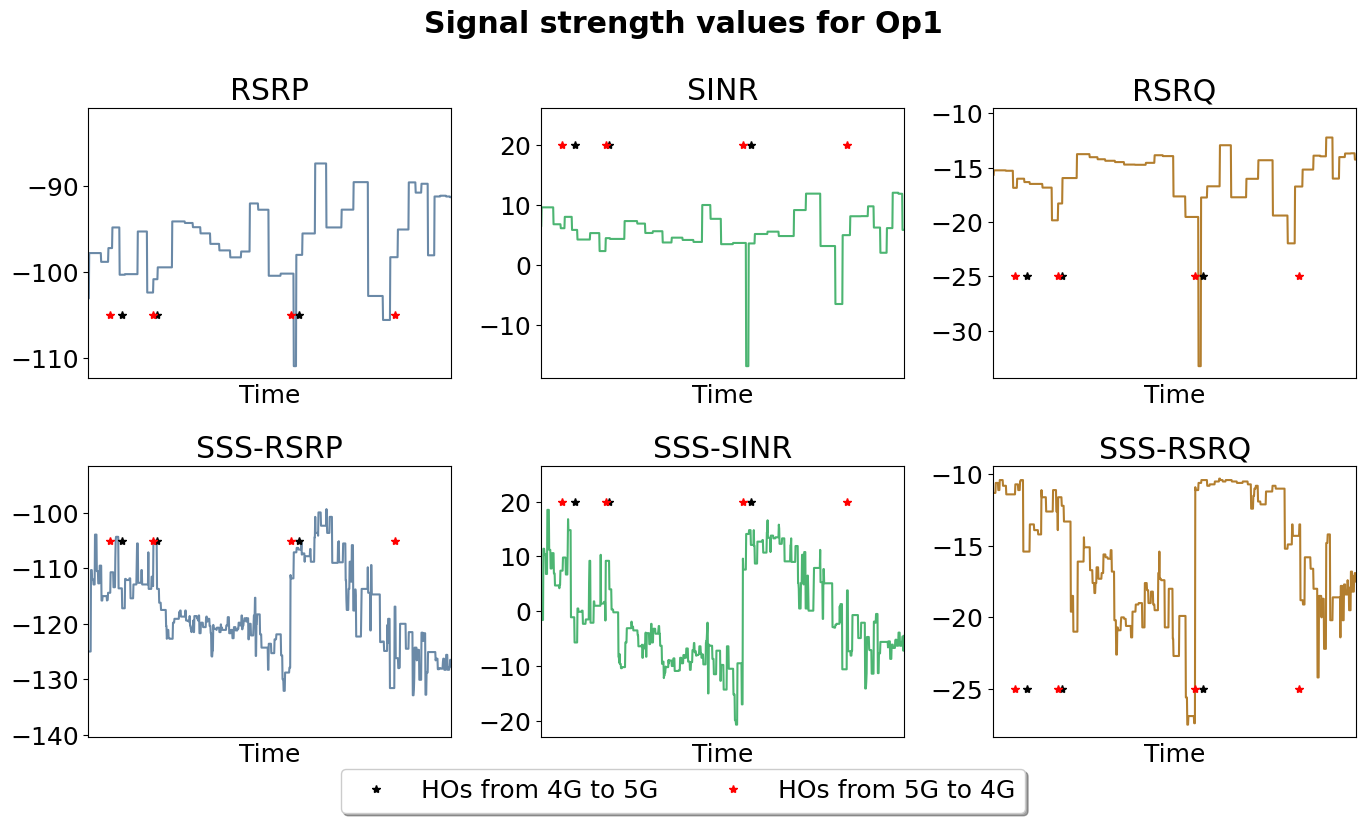

In [34]:
fig = plot_signal_strengths(op1_df_one_campaign, op1, xlim=(500, 1500))
fig.savefig(r'../latex/plots/overview/op1_signal_strength.pdf', bbox_inches='tight')

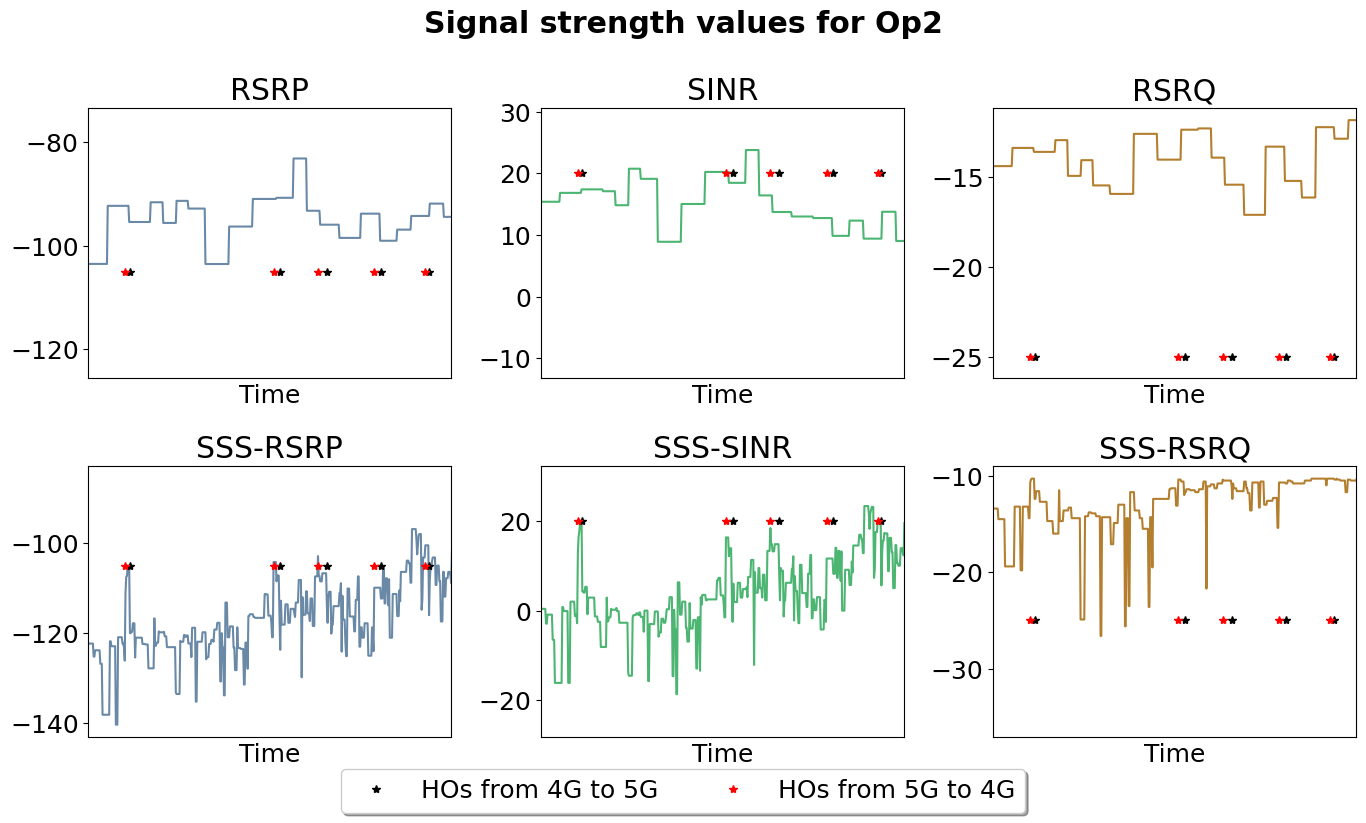

In [35]:
fig = plot_signal_strengths(op2_df_one_campaign, op2, xlim=(10, 500))
fig.savefig(r'../latex/plots/overview/op2_signal_strength.pdf', bbox_inches='tight')